In [1]:
# Install project requirements for this notebook
# Uses Jupyter %pip magic to install into the active kernel env
%pip install -q -r ../requirements.txt


Note: you may need to restart the kernel to use updated packages.


# Spotify Churn Dataset — EDA and Assignment Summary

This notebook inspects `spotify_churn_dataset.csv` and its metadata to verify assignment criteria and produce basic exploratory analysis and visuals you can reuse in your PDF presentation.


In [2]:
import json
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

DATA_DIR = Path.cwd().parent if (Path.cwd().name == 'notebooks') else Path.cwd()
CSV_PATH = DATA_DIR / 'spotify_churn_dataset.csv'
META_PATH = DATA_DIR / 'spotify-dataset-for-churn-analysis-metadata.json'

print('CSV exists:', CSV_PATH.exists(), 'size:', CSV_PATH.stat().st_size if CSV_PATH.exists() else 'NA')
print('Metadata exists:', META_PATH.exists())

df = pd.read_csv(CSV_PATH)
print('Rows, Columns:', df.shape)
df.head()


CSV exists: True size: 391588
Metadata exists: True
Rows, Columns: (8000, 12)


,user_id,gender,age,country,subscription_type,listening_time,songs_played_per_day,skip_rate,device_type,ads_listened_per_week,offline_listening,is_churned
0,1,Female,54,CA,Free,26,23,0.20,Desktop,31,0,1
1,2,Other,33,DE,Family,141,62,0.34,Web,0,1,0
2,3,Male,38,AU,Premium,199,38,0.04,Mobile,0,1,1
3,4,Female,22,CA,Student,36,2,0.31,Mobile,0,1,0
4,5,Other,29,US,Family,250,57,0.36,Mobile,0,1,1


In [3]:
# Basic data info
print('Columns:', list(df.columns))
print('\nDtypes:')
print(df.dtypes)

# Check target distribution
print('\nTarget value counts:')
print(df['is_churned'].value_counts(dropna=False))

# Simple missing check
missing = df.isna().sum().sort_values(ascending=False)
missing[missing > 0]


Columns: ['user_id', 'gender', 'age', 'country', 'subscription_type', 'listening_time', 'songs_played_per_day', 'skip_rate', 'device_type', 'ads_listened_per_week', 'offline_listening', 'is_churned']

Dtypes:
user_id                    int64
gender                    object
age                        int64
country                   object
subscription_type         object
listening_time             int64
songs_played_per_day       int64
skip_rate                float64
device_type               object
ads_listened_per_week      int64
offline_listening          int64
is_churned                 int64
dtype: object

Target value counts:
is_churned
0    5929
1    2071
Name: count, dtype: int64


Series([], dtype: int64)

In [4]:
# Read and summarize metadata
with open(META_PATH, 'r', encoding='utf-8') as f:
    meta = json.load(f)

meta_summary = {
    'name': meta.get('name'),
    'creator': (meta.get('creator') or {}).get('name'),
    'catalog': (meta.get('includedInDataCatalog') or {}).get('name'),
    'url': meta.get('url'),
    'license': ((meta.get('license') or {}).get('name'), (meta.get('license') or {}).get('url')),
    'datePublished': meta.get('datePublished'),
    'dateModified': meta.get('dateModified'),
    'synthetic': meta.get('alternateName'),
}
meta_summary


{'name': 'Spotify Analysis Dataset 2025',
 'creator': 'nabiha zahid',
 'catalog': 'Kaggle',
 'url': 'https://www.kaggle.com/datasets/nabihazahid/spotify-dataset-for-churn-analysis',
 'license': ('Apache 2.0', 'https://www.apache.org/licenses/LICENSE-2.0'),
 'datePublished': '2025-08-29T01:14:34.2805233',
 'dateModified': '2025-08-28T23:44:35.173',
 'synthetic': 'Synthetically generated dataset for EDA and ML'}

In [5]:
# Quick numeric summary
num_cols = df.select_dtypes(include=[np.number]).columns
summary = df[num_cols].describe().T
summary


,count,mean,std,min,25%,50%,75%,max
user_id,8000.0,4000.500000,2309.545410,1.0,2000.75,4000.5,6000.25,8000.0
age,8000.0,37.662125,12.740359,16.0,26.00,38.0,49.00,59.0
listening_time,8000.0,154.068250,84.015596,10.0,81.00,154.0,227.00,299.0
songs_played_per_day,8000.0,50.127250,28.449762,1.0,25.00,50.0,75.00,99.0
skip_rate,8000.0,0.300127,0.173594,0.0,0.15,0.3,0.45,0.6
ads_listened_per_week,8000.0,6.943875,13.617953,0.0,0.00,0.0,5.00,49.0
offline_listening,8000.0,0.747750,0.434331,0.0,0.00,1.0,1.00,1.0
is_churned,8000.0,0.258875,0.438044,0.0,0.00,0.0,1.00,1.0


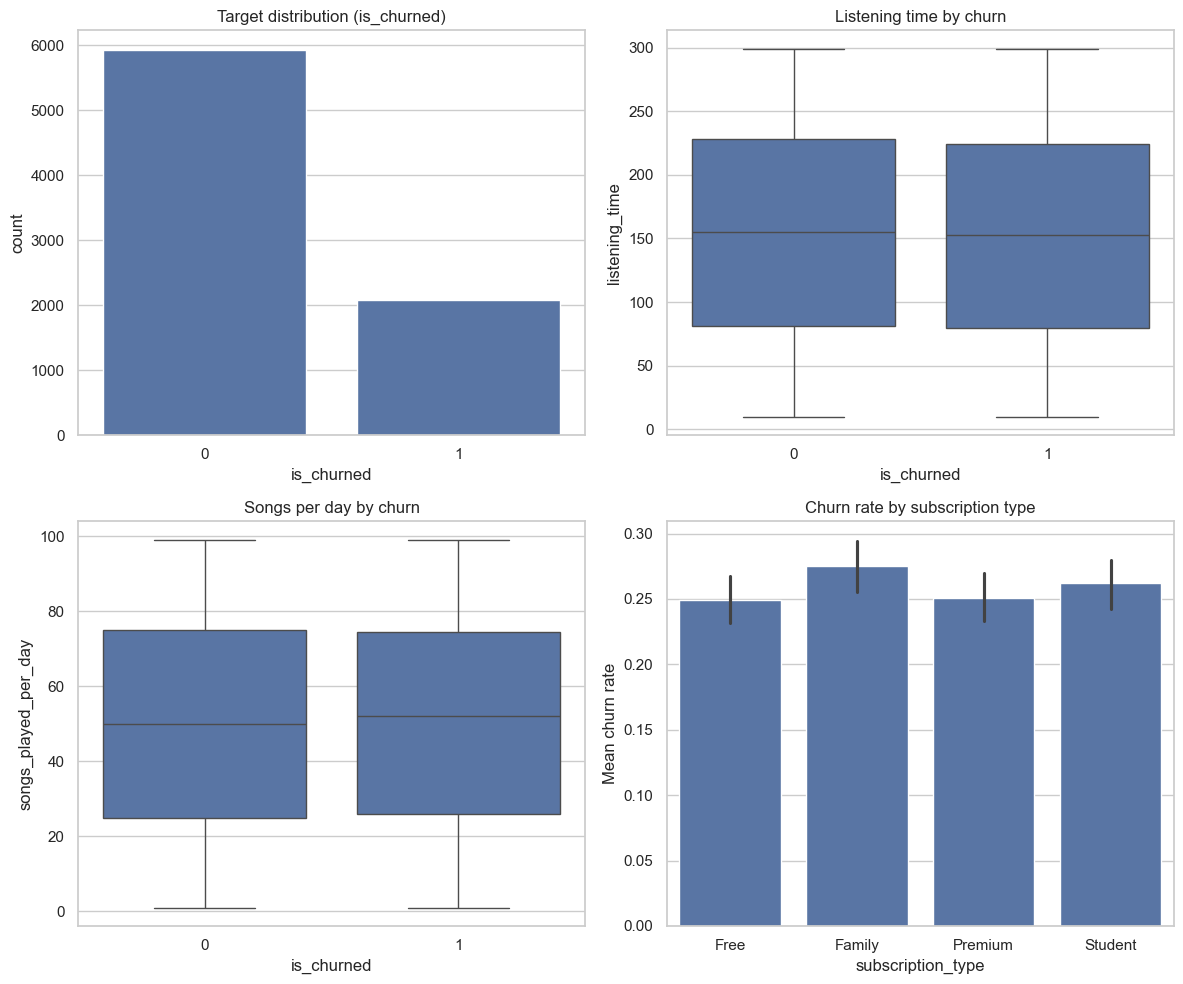

In [6]:
# Visuals
sns.set_theme(style='whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.countplot(data=df, x='is_churned', ax=axes[0,0])
axes[0,0].set_title('Target distribution (is_churned)')

sns.boxplot(data=df, x='is_churned', y='listening_time', ax=axes[0,1])
axes[0,1].set_title('Listening time by churn')

sns.boxplot(data=df, x='is_churned', y='songs_played_per_day', ax=axes[1,0])
axes[1,0].set_title('Songs per day by churn')

sns.barplot(data=df, x='subscription_type', y='is_churned', estimator=np.mean, ax=axes[1,1])
axes[1,1].set_title('Churn rate by subscription type')
axes[1,1].set_ylabel('Mean churn rate')
plt.tight_layout();


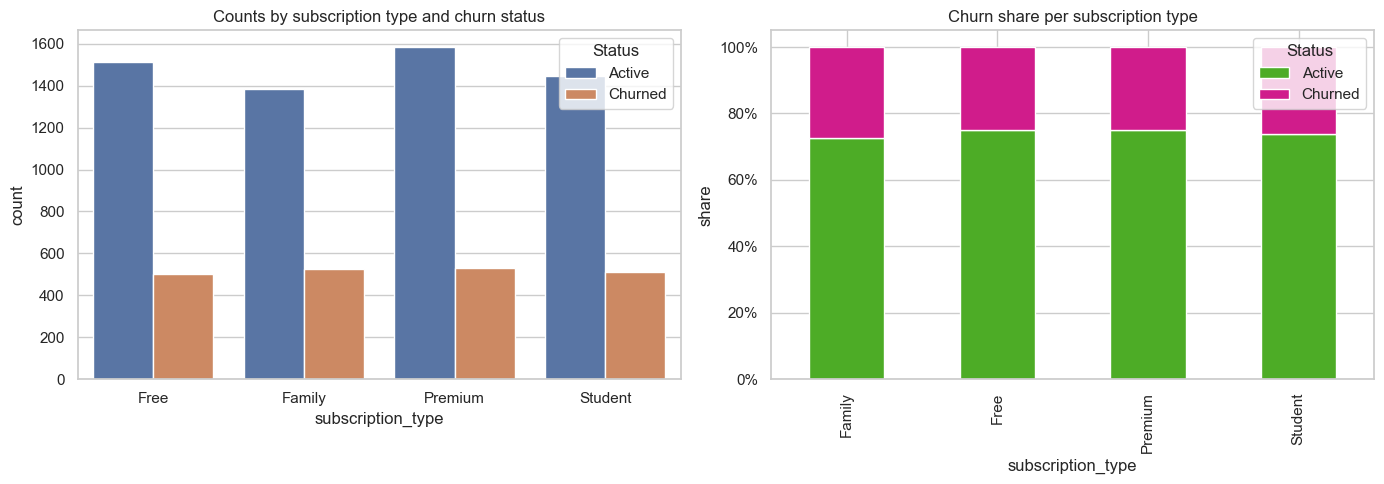

In [7]:
# Churn by subscription type: counts and percentage share
from matplotlib.ticker import PercentFormatter

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Counts per subscription_type split by churn status
sns.countplot(data=df, x='subscription_type', hue='is_churned', ax=axes[0])
axes[0].set_title('Counts by subscription type and churn status')
axes[0].set_xlabel('subscription_type')
axes[0].set_ylabel('count')
# Relabel legend for readability
handles, labels = axes[0].get_legend_handles_labels()
label_map = {'0': 'Active', '1': 'Churned', 0: 'Active', 1: 'Churned'}
axes[0].legend(handles=handles, labels=[label_map.get(l, l) for l in labels], title='Status')

# Percentage (share) per subscription_type (stacked) using crosstab
share = pd.crosstab(df['subscription_type'], df['is_churned'], normalize='index')
share = share.rename(columns={0: 'Active', 1: 'Churned'}).sort_index()

share[['Active', 'Churned']].plot(kind='bar', stacked=True, ax=axes[1], color=['#4dac26', '#d01c8b'])
axes[1].set_title('Churn share per subscription type')
axes[1].set_xlabel('subscription_type')
axes[1].set_ylabel('share')
axes[1].yaxis.set_major_formatter(PercentFormatter(1.0))
axes[1].legend(title='Status', loc='upper right')

plt.tight_layout();


## Notes for the presentation
- Source: Kaggle — "Spotify Analysis Dataset 2025" (Apache 2.0)
- Data type: synthetic, tabular; mixed numeric + categorical
- Rows represent users; target column: `is_churned` (0/1)
- Brief findings: include target balance, key descriptive stats, and 2–4 visuals above.
